<a href="https://colab.research.google.com/github/AikenChung/microBE/blob/main/MLP_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training process for MLP model

**Team: microBE**

@Ali, @Anthony, @Laura, @Aiken

In [ ]:
colab = True
from google.colab import drive
drive.mount('/content/drive')

from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


import os as os
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/data'):
    os.makedirs('/content/drive/My Drive/Colab Notebooks/data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, from_numpy, optim
import numpy as np
import pandas as pd

#progess bar
from tqdm import tqdm
import time
import easydict


if not os.path.exists('/content/drive/My Drive/Colab Notebooks/data/MLP_trainedModels'):
    os.makedirs('/content/drive/My Drive/Colab Notebooks/data/MLP_trainedModels')

if not os.path.exists('/content/drive/My Drive/Colab Notebooks/data/MLP_trainedResults'):
    os.makedirs('/content/drive/My Drive/Colab Notebooks/data/MLP_trainedResults')
    
modelFilePath = '/content/drive/My Drive/Colab Notebooks/data/MLP_trainedModels/'
resultFilePath = '/content/drive/My Drive/Colab Notebooks/data/MLP_trainedResults/'

In [ ]:
#================================== Setting ==================================
train_base_file = 'phyla_all_noNC_noCS_4050x1177_PMI_threshold_0_clr_plsda_85p.csv'
#train_base_file_url = 'https://drive.google.com/file/d/1BxK876BrT1aT2xVUaHafwiqBNxYw5bBn/view?usp=sharing'
train_data_prefix = 'phyla_all_noNC_noCS'
train_data_surfix_BE_method = 'plsda_BE'

args = easydict.EasyDict({
        "feature_Num": 1177,        # Number of features (columns) in the input data
        "epochs": 5000,             # Number of iterations to train Model for
        "hidden_dim": 256,          # Size of each hidden layer in Discriminator
        "pre_output_layer_dim": 64, # Size of each hidden layer in Discriminator
        "output_dim": 1,            # Size of output layer
        "mlp_hidden_layers_num": 1, # How many (middle or hidden) layers in Discriminator (ie. 'mlp':  w/o 1st & last; 'resnet's: num. resudual blocks)
        "batch_size": 32,           # Batch size
        "learning_rate": 0.001,     # Learning rate for the optimizer
        "beta1": 0.5,               # 'beta1' for the optimizer
        "adapt_lr_iters": 5,        # how often decrease the learning rate
})


fileNameToSave_base = ('MLP_'+ str(args.feature_Num) +'_'+ 
                               str(args.hidden_dim) + '_' + 
                               str(args.pre_output_layer_dim) + '_' +
                               str(args.output_dim) + '_Adam_lr_'+
                               str(args.learning_rate) + '_MSELoss_bSize'+
                               str(args.batch_size) + '_epoch'+
                               str(args.epochs) + '_'+train_data_prefix+'_'+
                               train_data_surfix_BE_method)


#============================== End of Setting ================================

In [ ]:

import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

file_list = drive.ListFile({'q': "'1aUlG3KemS6u9qKI3nT-4XEmWFNVQR3i_' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

data_downloaded = drive.CreateFile({'id': '1BxK876BrT1aT2xVUaHafwiqBNxYw5bBn'})
data_downloaded.GetContentFile('phyla_all_noNC_noCS_4050x1177_PMI_threshold_0_clr_plsda_85p.csv')

title: MLP_training.ipynb, id: 1ZRZq0htufNRxJz8EEcrkcZYu8wvWi6EB
title: data, id: 1-59EAqGGegW1WhPFgus9El9XyiDes6DM
title: phyla_all_noNC_noCS_4050x1177_PMI_threshold_0_clr_plsda_85p.csv, id: 1BxK876BrT1aT2xVUaHafwiqBNxYw5bBn
title: remote_SSH, id: 1d3_MsesxaLvZJg_v8L_3vdXTtllD2dX3
title: preprocessing_Dev, id: 1qo_mUWL0bWJh7Xq8zg5w4vH7skGeL8Mu
title: csvData, id: 1jFPVCcbL3ln7w1U-GUU4TWi9aCq2UMot
title: AI_in_Genomics_Assignments, id: 12vJGH4NHRDLyb7BYazjHJadCliupBVmq
title: phylaMLP.ipynb, id: 1WLwiwSJgUMW7C0DjLtxRSvoniSbbZ13t
title: NN_Classifier_LoadAndTest.ipynb, id: 1PFB2F2jPkZoQZgYyBdxuSzKiRGfHUrvK
title: phyla_data_PCA_UMAP.ipynb, id: 1OchVuECizQB7q0F3ZYRcmYlL-Ovka2UM
title: phyla_all_4514x1177_PMI_threshold_0_clr_plsda_85p.csv, id: 1ezFV1Yrb6mGCE965I3R_3_VYdjDMH28L
title: phyla_biopsy_noCS_1252x1177_PMI_threshold_0_clr_plsda_85p.csv, id: 12nuz96KhOZqCOe8cjC-68_gxwdOY80ib
title: phyla_biopsy_1273x1177_PMI_threshold_0_clr_plsda_85p.csv, id: 18pJf8SuGlUmgMp5ii2hHPpSG2VCDtNQS
titl

In [ ]:

# sets device for model and PyTorch url)tensors
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class PhylaDataset(Dataset):
    """ Phyla dataset"""
    """
    Dataset for binary classification IBD/Healthy
    """
    # Initialize your data, download, etc.
    def __init__(self, inputFile):
        ori_data = pd.read_csv(inputFile, low_memory=False, lineterminator='\n')
        phyla_input = ori_data[ori_data.columns[1:args.feature_Num+1]]
        phyla_input = phyla_input.assign(diagnosis=ori_data[ori_data.columns[args.feature_Num+2]])
        phyla_input = phyla_input.to_numpy(dtype=np.float32)
        self.len = phyla_input.shape[0]
        self.count_data = from_numpy(phyla_input[:, 0:-1])
        self.diagnosis_data = from_numpy(phyla_input[:, [-1]]) # 0: Control, 1: IBD

    def __getitem__(self, index):
        samples = self.count_data[index]
        labels = self.diagnosis_data[index]
        return samples, labels

    def __len__(self):
        return self.len
    


"""
Preparing data for training and validaing
"""

dataset = PhylaDataset(train_base_file) 
num_cohorts, num_genus = dataset.count_data.shape



In [ ]:

"""
We now need to split our dataset into two parts.
The **train set** will be used to train our model, and the **test set** will be used for evaluation.
First, let us compute the number of samples to put in each split. 
Here we choose to keep 80\% of the samples for training and 20\% for testing
"""

# starting time
start = time.time()

train_set_size = int(len(dataset) * 0.8)
validate_set_size = len(dataset) - train_set_size

"""Split randomly our dataset into two parts"""

train_dataset, validate_dataset = torch.utils.data.random_split(dataset, 
                                                            lengths=[train_set_size, validate_set_size], 
                                                            generator=torch.Generator().manual_seed(0))

"""
We initialize dataloader objects. 
These dataloaders will provide data one batch at a time, 
which is convenient to train our machine learning model.
"""

train_loader = DataLoader(train_dataset, 
                                           batch_size = args.batch_size, 
                                           shuffle=True)
validate_loader = DataLoader(validate_dataset, 
                                          batch_size = args.batch_size, 
                                          shuffle=True)

class MLP(nn.Module):
    """ Multi-Layer Perceptron for classifying IBD and Healthy microbiome data"""
    def __init__(self, input_dim=1177, hidden_dim=256, 
                 hidden_layer_num=1, 
                 pre_output_dim = 64, 
                 output_dim=1):        
        super(MLP, self).__init__()        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        for layer in range(hidden_layer_num):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, pre_output_dim))
        self.layers.append(nn.Linear(pre_output_dim, output_dim))
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        out = self.layers[-1](x)
        out = torch.sigmoid(out)
        return out

def training(model, loader, optimizer, criterion, device):
    running_loss = 0.0
    for i, data in enumerate(loader,0):
      # get the inputs; data is a list of [samples, labels]
      samples, labels = data
      
      # into the defined NN model in that device.
      samples = samples.to(device)
      labels = labels.to(device)
      
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(samples)
      loss = criterion(outputs, labels)
      loss.to(device)
      loss.backward()
      optimizer.step()  # Update the parameters of the model
          
      running_loss += loss.item()         
      return running_loss/len(loader)
       
    print('Finished Training')


def validating(model, data_loader, criterion, device):

  with torch.no_grad():
    pass_loss = 0.0
    for samples, labels in data_loader:
        samples = samples.to(device)
        labels = labels.to(device)
        outputs = model(samples)
        loss = criterion(outputs, labels)
        pass_loss += loss.item()
    
    return pass_loss/len(data_loader)


def run_training_process(model, nb_epochs, train_loader, validate_loader, optimizer, scheduler, criterion, fileNameForModel, device ):
  #Subjecting the define NN model to the device which can be CPU or GPU
  model = model.to(device)
  progress_bar = tqdm(range(nb_epochs), position=0, leave=True)
  loss_history = []
  for epoch in progress_bar:
      train_loss = training(model, train_loader, optimizer, criterion, device)
      test_loss = validating(model, validate_loader, criterion, device)
      loss_history.append(
          {"loss": train_loss, "set": "train", "epochs": epoch}
      )
      loss_history.append(
          {"loss": test_loss, "set": "validate", "epochs": epoch}
      )
      # save models during each training iteration
      checkpoint = {'model' : model.state_dict(), 'optimizer': optimizer.state_dict()}
      fileNameToSave = fileNameForModel + ".pt"
      if epoch % args.adapt_lr_iters == 0 :
          save_model(checkpoint,fileNameToSave)
          # Using scheduler to update the learning rate every 100 iterations.
          scheduler.step()
  return pd.DataFrame(loss_history)


def save_model(model_state, fileName):
    #print("=> Saving model")
    torch.save(model_state,fileName)

""" 
Define the evaluation metric:

We will use several evaluation metrics.
Accuracy = (TP+TN) / (TP+TN+FP+FN)
Specificity = TN / (TN+FP)
Recall (Sensitivity) = (TP) / (TP+FN)
Precision = TP / (TP+FP)
F1-score = (2*Precision*Recall) / (Precision+Recall)
MCC = (TP*TN - FP*FN) / sqrt((TP+FN)*(TP+FP)*(TN+FN)*(TN+FP))
"""

def compute_accuracy(loader, net):
    
    net = net.to(device)
    accuracy_compute_history = []
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    with torch.no_grad():      
        for data in loader:
            samples, labels = data
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = net(samples)           
            for i in range(labels.shape[0]):
                sample_val = labels[i,0]
                predict_val= outputs[i,0]
                if sample_val == 1:
                    if predict_val>0.5:
                        TP = TP + 1
                    else:
                        FN = FN + 1
                elif sample_val == 0:
                    if predict_val <= 0.5:
                        TN = TN + 1
                    else:
                        FP = FP + 1
    if (TP+FN) != 0:
        recall = TP/(TP+FN) # sensitivity
    if (TN+FP) != 0:
        specificity = TN/(TN+FP)
    if (TP+FP) != 0:
        precision = TP/(TP+FP)
    if (TP+TN+FP+FN) != 0:    
        accuracy = 100*(TP+TN)/(TP+TN+FP+FN)
    if (precision+recall) != 0:
        f1 = (2*precision*recall)/(precision+recall)
    mcc = (TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  # Matthews correlation coefficient
    accuracy_compute_history.append(
        {"TP": TP, "TN": TN, "FP":FP, "FN": FN,
         "Recall":recall, "Specificity":specificity,
         "Precision":precision, "Accuracy":accuracy,
         "F1-score":f1, "MCC":mcc}
    )
    return accuracy_compute_history

def writeResult(fileName, dataObj, modelName, testingFileName):
    with open(fileName, 'w') as f:
        theFirstLine = 'Model file: '+modelName+'\n'
        f.write(theFirstLine)
        theSecondLine = 'Test file: '+testingFileName+'\n'
        f.write(theSecondLine)
        for item in dataObj[0]:
            strToWrite = "{0}: {1}\n".format(item, np.round(dataObj[0][item], decimals=2))
            f.write(strToWrite)



In [ ]:
"""
Start to train the MLP model
"""
# Initilize model, criterion, optimizer. Then train the model
classifierMLP = MLP(args.feature_Num, args.hidden_dim, 
                         args.mlp_hidden_layers_num, 
                         args.pre_output_layer_dim, args.output_dim)

# cost function (for predicting labels)
#criterion = torch.nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss(reduction='sum')

# setup optimizer
optimizer_mlp = optim.Adam(list(classifierMLP.parameters()), lr=args.learning_rate, betas=(args.beta1, 0.999))
# use an exponentially decaying learning rate
scheduler_mlp= optim.lr_scheduler.ExponentialLR(optimizer_mlp, gamma=0.99)

modelNameToSave = modelFilePath + fileNameToSave_base
training_history = run_training_process(classifierMLP, args.epochs, train_loader, validate_loader, optimizer_mlp, scheduler_mlp, criterion, modelNameToSave, device=device )




100%|██████████| 5000/5000 [03:44<00:00, 22.28it/s]


Accuracy of the MLP on the 3240 train samples: 98 %
Accuracy of the MLP on the 810 validation samples: 89 %


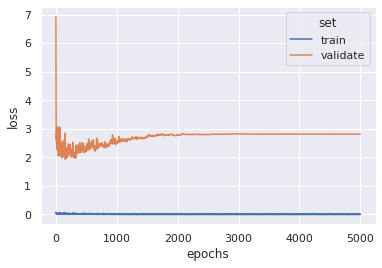

In [ ]:
train_dataset_metric = compute_accuracy(train_loader, classifierMLP)
train_dataset_metric_nameToSave = resultFilePath + fileNameToSave_base + "_train_result_metric.txt"
validation_dataset_metric = compute_accuracy(validate_loader, classifierMLP)
validation_dataset_metric_nameToSave = resultFilePath + fileNameToSave_base + "_validation_result_metric.txt"

writeResult(train_dataset_metric_nameToSave, train_dataset_metric, fileNameToSave_base, train_base_file)
validationFileName = train_base_file[0:len(train_base_file)-4]+"_validation"
writeResult(validation_dataset_metric_nameToSave, validation_dataset_metric, fileNameToSave_base, validationFileName)
        
print('Accuracy of the MLP on the ' + str(len(train_dataset)) + ' train samples: %d %%' % train_dataset_metric[0]["Accuracy"])

print('Accuracy of the MLP on the ' + str(len(validate_dataset)) + ' validation samples: %d %%' % validation_dataset_metric[0]["Accuracy"])

training_history.head()


plt.figure()
ax = sns.lineplot(x="epochs", y="loss", hue= "set", data=training_history)
fig_trainHistory = ax.get_figure()
training_history_plotName = resultFilePath + fileNameToSave_base +'_training_history.png'
fig_trainHistory.savefig(training_history_plotName)
